In [42]:
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import glob
from collections import Counter

In [43]:
nc_files = sorted(glob.glob("C:/Users\locfa_v05v5qi/Documents/escadas_termohalinas/raw/Dataset/**/*.nc", recursive=True))

In [44]:
def subset_region(ds):

    # Ajustar longitudes se estiverem em 0–360
    if float(ds.lon.max()) > 180:
        ds = ds.assign_coords(
            lon=((ds.lon + 180) % 360) - 180
        )

    mask = (
        (ds.lat <= 10) & (ds.lat >= -60) &
        (ds.lon >= -50) & (ds.lon <= -10)
    )

    if "Nobs" in ds.dims:
        ds = ds.isel(Nobs=mask)

    return ds

In [53]:
# só regimes mistos
sequence_list = []
df_misto = {
    "lat": [],
    "depth": [],
    "regime": [],
    "thickness":[]
}

for fname in nc_files:
    try:
        ds = xr.open_dataset(fname)
        ds = subset_region(ds)

        nobs = ds.sizes.get("Nobs", 0)
        if nobs == 0:
            ds.close()
            continue

        for i in range(nobs):

            lat = float(ds.lat[i])

            sf_mask = ds.mask_ml_sf_layer[i, :].values
            dc_mask = ds.mask_ml_dc_layer[i, :].values

            idx_sf = np.where(sf_mask > 0)[0]
            idx_dc = np.where(dc_mask > 0)[0]

            # PERFIL MISTO = tem SF e DC
            if len(idx_sf) > 0 and len(idx_dc) > 0:

                layers = []

                # Adiciona SF
                for j in idx_sf:
                    depth = float(ds.ml_p[i, j])
                    thickness = float(ds.ml_h[i, j])
                    layers.append((depth, "SF"))
                    df_misto["thickness"].append(thickness)
                    

                # Adiciona DC
                for j in idx_dc:
                    depth = float(ds.ml_p[i, j])
                    thickness = float(ds.ml_h[i, j])
                    layers.append((depth, "DC"))
                    df_misto["thickness"].append(thickness)
                    

                # Ordena verticalmente
                layers_sorted = sorted(layers, key=lambda x: x[0])

                # Cria sequência
                sequence = "-".join([layer[1] for layer in layers_sorted])
                sequence_list.append(sequence)

                # Salva para scatter
                for depth, regime in layers_sorted:
                    df_misto["lat"].append(lat)
                    df_misto["depth"].append(depth)
                    df_misto["regime"].append(regime)

        ds.close()

    except Exception as e:
        print("Erro em", fname, "->", e)
        
df_misto = pd.DataFrame(df_misto)

In [46]:
sequence_counts = Counter(sequence_list)

print("Sequências mais comuns:")
for seq, count in sequence_counts.most_common(10):
    print(seq, "->", count)

Sequências mais comuns:
SF-SF-DC-DC -> 771
SF-SF-SF-SF-DC-DC -> 452
SF-SF-DC-DC-DC-DC -> 405
DC-DC-SF-SF -> 289
SF-SF-DC-DC-DC-DC-DC-DC -> 256
SF-SF-SF-SF-DC-DC-DC-DC -> 246
SF-SF-SF-SF-SF-SF-DC-DC -> 224
SF-SF-DC-DC-SF-SF -> 137
SF-SF-SF-SF-SF-SF-DC-DC-DC-DC -> 132
SF-SF-SF-SF-DC-DC-DC-DC-DC-DC -> 132


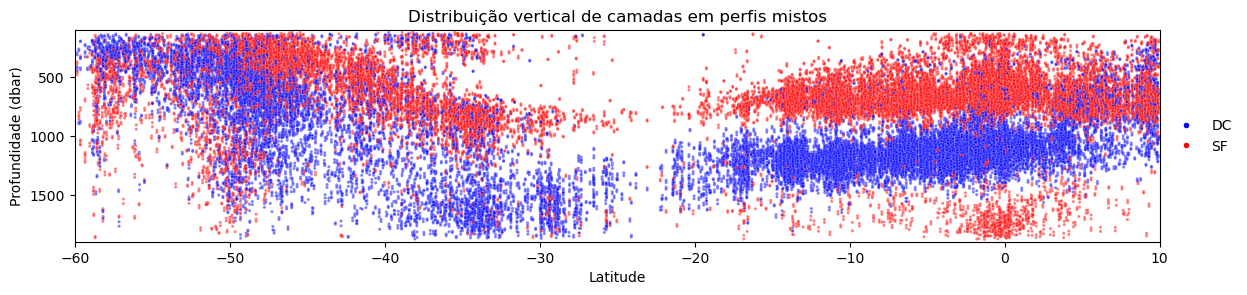

In [51]:
fig = plt.figure(figsize=(14, 2.75))

ax = sns.scatterplot(
    data=df_misto,
    x="lat",
    y="depth",
    s=5,
    hue="regime",
    alpha=0.5,
    palette={
        "DC": "blue",
        "SF": "red",
    }
)

ax.set_xlim(-60, 10)
ax.set_ylim(100, 1900)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='DC',
           markerfacecolor='blue', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='SF',
           markerfacecolor='red', markersize=5),
]

plt.legend(
    handles=legend_elements,
    frameon=False,
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.gca().invert_yaxis()  # profundidade aumenta para baixo
plt.xlabel("Latitude")
plt.ylabel("Profundidade (dbar)")
plt.title("Distribuição vertical de camadas em perfis mistos")
plt.show()

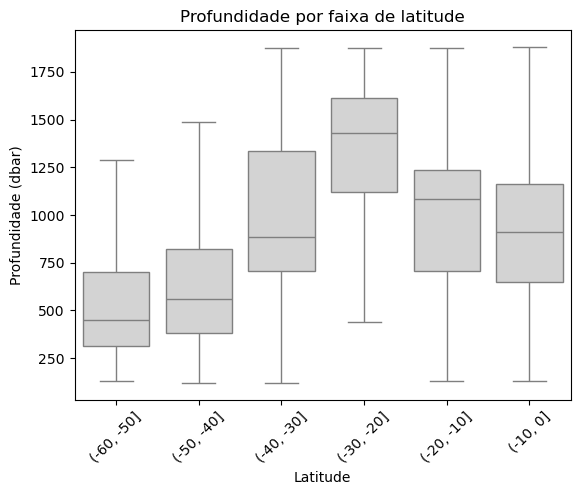

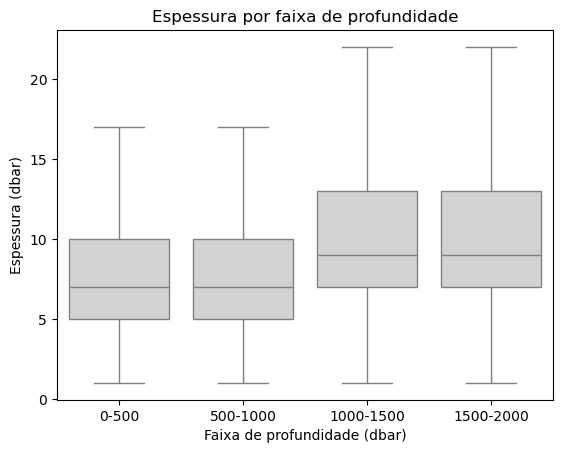

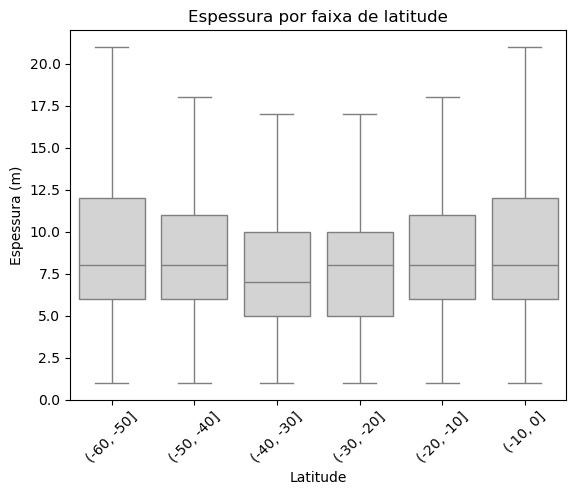

In [54]:
df_misto["lat_bin"] = pd.cut(
    df_misto["lat"],
    bins=np.arange(-60, 10, 10)
)

df_misto["depth_bin"] = pd.cut(
    df_misto["depth"],
    bins=[0, 500, 1000, 1500, 2000],
    labels=["0-500", "500-1000", "1000-1500", "1500-2000"]
)

plt.figure()
sns.boxplot(data=df_misto, x="lat_bin", y="depth", color="lightgrey", showfliers=False)
plt.xticks(rotation=45)
plt.title("Profundidade por faixa de latitude")
plt.xlabel("Latitude")
plt.ylabel("Profundidade (dbar)")
plt.show()

plt.figure()
sns.boxplot(data=df_misto, x="depth_bin", y="thickness", color="lightgrey", showfliers=False)
plt.title("Espessura por faixa de profundidade")
plt.xlabel("Faixa de profundidade (dbar)")
plt.ylabel("Espessura (dbar)")
plt.show()

plt.figure()
sns.boxplot(data=df_misto, x="lat_bin", y="thickness", color="lightgrey", showfliers=False)
plt.xticks(rotation=45)
plt.title("Espessura por faixa de latitude")
plt.xlabel("Latitude")
plt.ylabel("Espessura (m)")
plt.show()

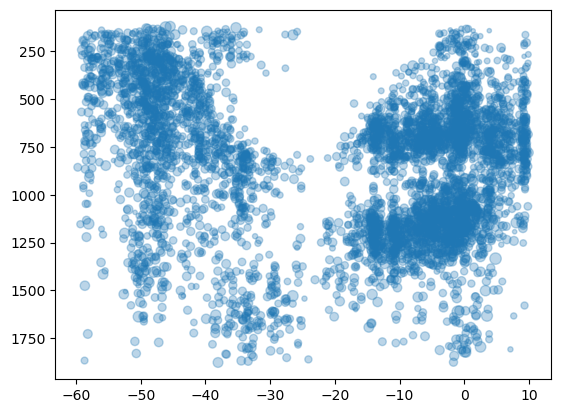

In [57]:
df_misto = df_misto.sample(frac=0.3, random_state=42)
plt.scatter(
    df_misto["lat"],
    df_misto["depth"],
    s=np.sqrt(df_misto["thickness"])*10,
    alpha=0.3
)

plt.gca().invert_yaxis()
plt.show()

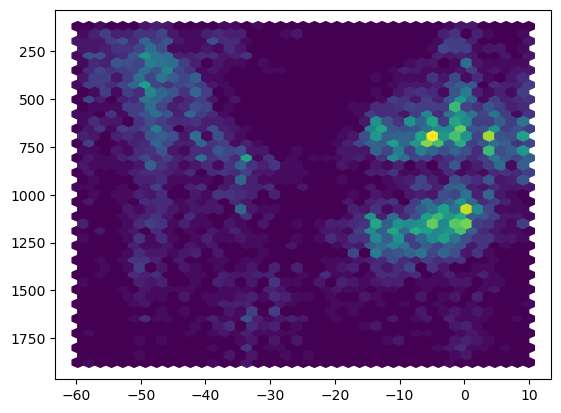

In [58]:
plt.hexbin(
    df_misto["lat"],
    df_misto["depth"],
    gridsize=40
)

plt.gca().invert_yaxis()
plt.show()